# SPASE Record Analysis - How to Use <br>
**START HERE**. For more documentation on how to add to this project, view the related notebook subtitled "How to Add Capability." <br>
<br>
This project aims to aid in analyzing FAIR for the SPASE records in the NumericalData and DisplayData categories.<br>

This notebook shows you how to convert desired SPASE record fields into a SQLite database. The desired fields correspond to metadata extracted from XML files using ElementTree. Also shown is how to query data from said database. <br> 
- The tutorial I used to implement ElementTree is <a href="https://realpython.com/python-xml-parser/" target="_blank">here</a>. 
- If more context is needed for the SQLite code than is provided by the comments, I recommend visiting <a href="https://www.sqlitetutorial.net/" target="_blank">this link</a>.<br>
<br>

First, clone the <a href="https://github.com/hpde/NASA/tree/master" target="_blank">NASA SPASE Github Repository</a> by executing the following code. After that, make sure you have the necessary packages and Python scripts imported below, which can be found in the same repo you found this notebook, linked again <a href="https://github.com/Kurokio/HDRL-Internship-2024" target="_blank">here</a>.<br>

In [ ]:
! git clone -b master --single-branch --depth=1 https://github.com/hpde/NASA

## Scraping the SPASE records and populating our tables
<br>
This code block performs the following: <br>

- takes user input of the absolute path of a SPASE directory they wish to be scraped <br>
- finds all desired metadata <br>
- creates all needed tables <br>
- adds an entry for each record found into the MetadataEntries table. <br>
- stores the locations of where each metadata field is found in the MetadataSources table <br>
- adds entries into the Records table with general info and info needed for database maintenance.<br>
- populate the TestResults table with default values. <br>
- update the columns associated with a given analysis test (i.e records that have authors -> has_author column) to have a 'True' value of 1.<br>
<br>

If you want a full printout of everything being done, pass True as the printFlag argument to Create.<br>
If you want to redo the MetadataEntries table, you will need to delete the table to get a clean slate and then run the function, passing False as the argument to update. <br>
<br>
Examples are also found as comments at the bottom of the code block to test smaller, yet complex directories.<br>

*Note that this code was designed to work for the NumericalData and DisplayData directories, so inputting directories besides those two may cause logical errors and produce unintended results.*

In [1]:
# import main Python function
from main import Create
#from SQLiteFun import executionALL

help(Create)

Help on function Create in module main:

Create(printFlag=False)
    Scrapes all records that are found in the directory given for the desired metadata. Creates the MetadataEntries, 
    MetadataSources, Records, and TestResults tables and populates them using the data scraped for each record. Populates the    TestResult table with default values to be overwritten by the call to the FAIRScorer function in the notebook.
    
    :param printFlag: A boolean determining if the user wants to print more details of what the function is doing.
    :type conn: Boolean
    :param update: A boolean determining if updating the MetadataEntries table or not
    :type entry: Boolean



In [ ]:
# takes printFlag as first arg (True prints, default False does not)
# takes update as second arg (default True just updates existing entries in table)
Create()

# run these lines if want to start from scratch
#executionALL("DROP TABLE MetadataEntries")
#Create()

# call .py file directly from notebook
#%run ./SPASE_test.py {path} in notebook
#import sys
#args = sys.argv
#path = args[1] in source file

# test paths : 
# Overall paths: /home/jovyan/NASA/NumericalData 
# AND /home/jovyan/NASA/DisplayData

# Smaller subdirectory = "/home/jovyan/NASA/NumericalData/DE2" 
# OR Bigger subdirectory = "/home/jovyan/NASA/NumericalData/ACE"

# complex author ex: /home/jovyan/NASA/NumericalData/Cassini/MAG/PT60S.xml 
# OR /home/jovyan/NASA/NumericalData/ACE/Attitude/Definitive/PT1H.xml

# complex URL ex: /home/jovyan/NASA/NumericalData/ACE/CRIS/L2/P1D.xml


## Executing Analysis Tests and Viewing the Results <br>
In this code block, we perform calls to the QueryPrinter script to get the Counts and/or ID's of the SPASE records that pass each analysis test. 
These analysis tests include links that have: <br> 

- authors <br>
- publishers <br>
- publication years <br>
- dataset names <br>
- licenses <br>
- URLs <br>
- NASA URLs <br>
- persistent identifiers <br>
- descriptions <br>
- citation info <br>
- DCAT-3 compliance info.<br>

In [1]:
from main import View

help(View)

Help on function View in module main:

View()
    Creates Counts and Links objects to print the number of records that meet each test criteria as well as return those links     to the caller in the form of a tuple.
    
    :return: A tuple containing lists of all records that fulfill certain test criteria.
    :rtype: tuple



In [1]:
# this function returns all records that pass associated tests
(allRecords, authorRecords, pubRecords, pubYrRecords, datasetNameRecords, licenseRecords, urlRecords, NASAurlRecords, 
     PIDRecords, descriptionRecords, citationRecords, complianceRecords) = View()

There are 3029 records total
There are 2902 records with at least one author
There are 3029 records with a publisher
There are 1879 records with a publication year
There are 3029 records with a dataset name
There are 0 records with a license
There are 3029 records with a url
There are 2249 records with a NASA url
There are 3029 records with a persistent identifier
There are 3029 records with a description
There are 1879 records with citation info
There are 3029 records that meet DCAT-US3 compliance


## Calculating the FAIR Scores
This code overwrites the default values placed in the TestResults table to have the actual FAIR Scores that are calculated according to the following algorithm:<br>

- +1 for author
- +1 for dataset name
- +1 for publication year
- +1 for publisher
- +1 for citation info
- +1 for description
- +1 for PID
- +1 for compliance
- +1 for license
- +1 for NASA URL <br>
======================= <br>
- Total Possible Points of 10

In [1]:
from SQLiteFun import FAIRScorer

help(FAIRScorer)

Help on function FAIRScorer in module SQLiteFun:

FAIRScorer(records, first)
    Iterates through the has_x column names of the TestResults table to calculate the FAIR Score of all the records in
    the parameter. For each record, its score is printed. FAIR Score is calculated according to the algorithm described in the    notebook. Once the FAIR score is calculated, the FAIR_Score, MostRecent, and FAIR_ScoreDate columns are updated for that     record. If it is the first time updating the FAIR Score after default values assigned, functionality that replaces these     default values before adding new rows for each subsequent FAIR Score update is provided by the 'first' parameter. If first     time, drop the trigger if needed and pass True. Otherwise, pass False.
    
    :param records: A list of all the links in table.
    :type records: list
    :param first: A boolean indicating if this is the first time populating the TestResults table after assigning its default 
                

In [ ]:
# calculate FAIR scores for all records

# pass True as a second optional argument if you wish to overwrite rows instead of adding new ones 
# and execute commented code
# execution("DROP TRIGGER FAIR_Update")


FAIRScorer(allRecords)

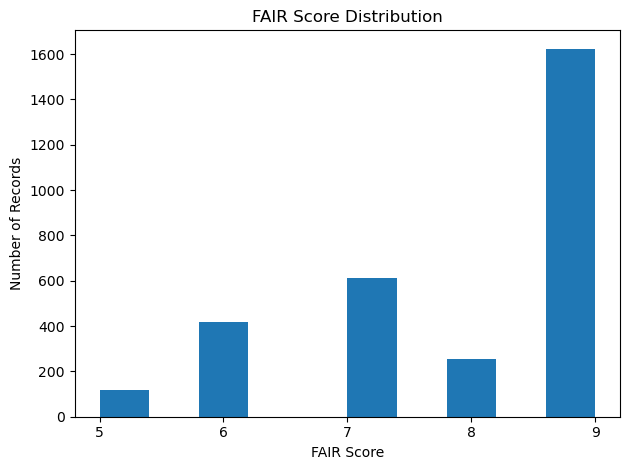

In [49]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# create histogram of FAIR scores
# number of records at each score and avg reported in corner of chart
scores = []
# get all FAIR scores from TestResults
stmt = "SELECT FAIR_Score FROM TestResults"
rows = execution(stmt,2)
for row in rows:
    #print(row[0])
    scores.append(row[0])
    
# assemble into Numpy array
np_scores = np.array(scores)
values = np.unique(np_scores)
#print(round(np_scores.mean))

# create chart
fig, ax = plt.subplots()
ax.hist(np_scores)
ax.set_title("FAIR Score Distribution")
ax.set_xlabel("FAIR Score")
ax.set_ylabel("Number of Records")
ax.set_xticks(values)
'''ax.text(0.99, 0.8, f'Average FAIR Score = {np_scores.mean()}', horizontalalignment='right',
        rotation='horizontal')'''
#ax.set_xlim((min(np_scores), max(np_scores)))
fig.tight_layout()

## How to do your own queries 
This section gives examples of how to query the database for row specific and column specific queries. Also provided are brief explanations of some of the SQLite syntax and also an example of a complex query for both categories. <br>

If more context is needed for the SQLite code than is provided by the comments, I recommend visiting <a href="https://www.sqlitetutorial.net/" target="_blank">this link</a>.<br>

*Disclaimer: Not all authors are provided, as checks were only done to find if an allowed author exists.* 
<br>
**Also note that when a SPASE record has multiple product keys for one URL or multiple URLs in general, each URL/product key gets their own entry into the table. This is why there may be 'duplicate entries' in the database.**

### Understanding the structure
This code block shows you all the table names and their column names in the database that was used.

In [1]:
from SQLiteFun import databaseInfo

help(databaseInfo)

Help on function databaseInfo in module SQLiteFun:

databaseInfo()
    Prints all table names and all the names of their associated columns



In [17]:
databaseInfo()

The table MetadataSources has columns:
['rowNum', 'SPASE_id', 'author_source', 'publisher_source', 'publication_yr_source', 'datasetName_source', 'license_source', 'datalink_source', 'description_source', 'PID_source']

The table Records has columns:
['rowNum', 'SPASE_id', 'SPASE_Version', 'LastModified', 'SPASE_URL']

The table MetadataEntries has columns:
['rowNum', 'SPASE_id', 'author', 'authorRole', 'publisher', 'publicationYr', 'datasetName', 'license', 'URL', 'prodKey', 'description', 'PID']

The table TestResults has columns:
['rowNum', 'SPASE_id', 'FAIR_Score', 'FAIR_ScoreDate', 'MostRecent', 'has_author', 'has_pub', 'has_pubYr', 'has_datasetName', 'has_license', 'has_url', 'has_NASAurl', 'has_PID', 'has_desc', 'has_citation', 'has_compliance', 'Errors']



### Record Specific Queries

In [4]:
from SQLiteFun import execution

help(execution)

Help on function execution in module SQLiteFun:

execution(stmt, number=1)
    Connects to the given SQLite database, creates a cursor object, and calls the execute method 
    with the stmt argument. Calls the fetchall method to get all rows returned by the statement that 
    was executed. This also displays error messages if any arise. Lastly, it returns the results of 
    the SQLite statement in a list
    
    :param stmt: A string of the SQLite statement to be executed.
    :type stmt: String
    :return: The list of the results from the SQLite statement
    :rtype: list



In [5]:
# brief SQLite command tutorial
# Use """SELECT columnName FROM TableName WHERE columnName = x""" where x is of proper data type

# Ex: How to get a ResourceID
stmt = """ SELECT SPASE_id FROM MetadataEntries WHERE rowNum = 10 """
execution(stmt)

['spase://NASA/NumericalData/Interball-2/IMAP3/PT120S']

In [2]:
# Get RID by specifying the xml file name
# Use "LIKE '%text%'" instead of '= x' for when you need to query on partial info
# Use DISTINCT to prevent duplicate rows
stmt = """ SELECT DISTINCT(SPASE_id) FROM MetadataEntries WHERE SPASE_id LIKE '%IMAP3/PT120S' """
execution(stmt)

['spase://NASA/NumericalData/Interball-2/IMAP3/PT120S']

In [15]:
# searching table for RID by a specific value of a column
ds = "Interball Aurora MAG 2-min Key Parameters"
stmt = f""" SELECT DISTINCT(SPASE_id) FROM MetadataEntries WHERE datasetName = '{ds}' """
execution(stmt)

['spase://NASA/NumericalData/Interball-2/IMAP3/PT120S']

In [16]:
# How to get all data for a SPASE record using the RID
# put any number besides 1 as the second optional arg for execution when selecting more than 1 item
ID = "spase://NASA/NumericalData/Interball-2/IMAP3/PT120S"
stmt = f""" SELECT * FROM MetadataEntries WHERE SPASE_id = '{ID}' """
rows = execution(stmt, 2)
for row in rows:
    print(row)

(9, 'spase://NASA/NumericalData/Interball-2/IMAP3/PT120S', 'spase://SMWG/Person/Vladislav.M.Petrov', 'GeneralContact', 'NASA/GSFC/SPDF', '', 'Interball Aurora MAG 2-min Key Parameters', 'Open', 'ftps://spdf.gsfc.nasa.gov/pub/data/interball/aurora/mfi/', '', 'Interball Auroral Magnetometer, 2-min key parameters, field intensity and index', '')
(10, 'spase://NASA/NumericalData/Interball-2/IMAP3/PT120S', 'spase://SMWG/Person/Vladislav.M.Petrov', 'GeneralContact', 'NASA/GSFC/SPDF', '', 'Interball Aurora MAG 2-min Key Parameters', 'Open', 'https://spdf.gsfc.nasa.gov/pub/data/interball/aurora/mfi/', '', 'Interball Auroral Magnetometer, 2-min key parameters, field intensity and index', '')
(11, 'spase://NASA/NumericalData/Interball-2/IMAP3/PT120S', 'spase://SMWG/Person/Vladislav.M.Petrov', 'GeneralContact', 'NASA/GSFC/SPDF', '', 'Interball Aurora MAG 2-min Key Parameters', 'Open', 'https://cdaweb.gsfc.nasa.gov/cgi-bin/eval2.cgi?dataset=IA_K0_MFI&index=sp_phys', 'IA_K0_MFI', 'Interball Auroral

In [15]:
# how to get the Fair Score for a record
ID = "spase://NASA/NumericalData/Interball-2/IMAP3/PT120S"
stmt = f""" SELECT DISTINCT(FAIR_Score) FROM TestResults WHERE SPASE_id = '{ID}' """
execution(stmt)

[7]

In [14]:
# complex example of selecting multiple items from multiple tables by using the RID
# notice we use commas for multiple items and INNER JOINS when multiple tables
ID = "spase://NASA/NumericalData/Interball-2/IMAP3/PT120S"
rows = execution(f""" SELECT author, MetadataSources.author_source, Records.SPASE_URL 
            FROM MetadataEntries
                INNER JOIN MetadataSources USING (SPASE_id)
                INNER JOIN Records USING (SPASE_id)
            WHERE SPASE_id = '{ID}';""", 2)
print(rows[0])

('spase://SMWG/Person/Vladislav.M.Petrov', 'NumericalData/ResourceHeader/Contact/PersonID', 'https://github.com/hpde/NASA/blob/master/NumericalData/Interball-2/IMAP3/PT120S.xml')


### Column Specific Queries

In [13]:
# How many records do not have a URL?
stmt = """SELECT COUNT(DISTINCT(SPASE_id)) FROM TestResults WHERE has_url = 0"""
execution(stmt)

[0]

In [14]:
# What are some examples of SPASE_id's of the records that do not have a NASA URL?
# Use optional LIMIT x at end to limit how many items are selected
stmt = """SELECT DISTINCT(SPASE_id) FROM TestResults WHERE has_NASAurl = 0 LIMIT 10"""
execution(stmt)

['spase://NASA/NumericalData/OV3-3/MES/PT1S',
 'spase://NASA/NumericalData/CRRES/LPI/PT30S',
 'spase://NASA/NumericalData/CRRES/MAG/PT30S',
 'spase://NASA/NumericalData/CRRES/MAG/PT2S',
 'spase://NASA/NumericalData/CRRES/PWE/PT8S',
 'spase://NASA/NumericalData/CORONAS-F/SPIRIT/PT5M',
 'spase://NASA/NumericalData/SCATHA/Science/PT1M',
 'spase://NASA/NumericalData/SCATHA/Science/PT1S',
 'spase://NASA/NumericalData/LANL/Avg/SOPA/PT1D',
 'spase://NASA/NumericalData/LANL/Avg/ESP/P1D']

In [12]:
# How many records have 3 out of 4 fields needed for citation?
# Use AND and OR operators
stmt = """SELECT COUNT(DISTINCT SPASE_id) FROM TestResults 
                WHERE (has_author = 1 
                AND has_datasetName = 1
                AND has_pubYr = 1)
                OR (has_author = 1 
                AND has_datasetName = 1
                AND has_pub = 1)
                OR (has_author = 1 
                AND has_pub = 1
                AND has_pubYr = 1)
                OR (has_datasetName = 1 
                AND has_pub = 1
                AND has_pubYr = 1)"""
execution(stmt)

[2902]

In [11]:
# how did records in a certain directory do in terms of FAIR scores?
stmt = """SELECT DISTINCT(FAIR_Score), SPASE_id FROM TestResults WHERE SPASE_id LIKE '%/ACE/%' LIMIT 10"""
execution(stmt)

[(8, 'spase://NASA/NumericalData/Weygand/ACE/TAP/Propagated.SWEPAM/GSE/PT60S'),
 (8,
  'spase://NASA/NumericalData/Weygand/ACE/SWEPAM/Propagated.SWEPAM/GSE/PT60S'),
 (6,
  'spase://NASA/NumericalData/Weygand/ACE/SWEPAM/Propagated.SWEPAM/GSM/PT60S'),
 (8, 'spase://NASA/NumericalData/Weygand/ACE/SWEPAM/Processed/GSE/PT60S'),
 (8, 'spase://NASA/NumericalData/Weygand/ACE/SWEPAM/Processed/GSM/PT60S'),
 (8, 'spase://NASA/NumericalData/Weygand/ACE/MFI/Propagated.SWEPAM/GSE/PT60S'),
 (8, 'spase://NASA/NumericalData/Weygand/ACE/MFI/Propagated.SWEPAM/GSM/PT60S'),
 (8, 'spase://NASA/NumericalData/Weygand/ACE/MFI/Processed/GSE/PT60S'),
 (8, 'spase://NASA/NumericalData/Weygand/ACE/MFI/Processed/GSM/PT60S'),
 (8, 'spase://NASA/NumericalData/ACE/SEPICA/PT120S')]

In [6]:
# how many records have a FAIR Score of x?
stmt = """SELECT COUNT(DISTINCT SPASE_id) FROM TestResults WHERE FAIR_Score = 9 """
execution(stmt)

[1624]